# 🔍 Detecção de Fraudes Bancárias - Dataset BankSim

## Sobre o Dataset
O **BankSim** é um simulador baseado em agentes que gera dados sintéticos de transações bancárias para pesquisa em detecção de fraudes.

- **Total de registros**: ~594.643
- **Transações normais**: ~587.443 (98.79%)
- **Transações fraudulentas**: ~7.200 (1.21%)
- **Período simulado**: 180 steps (~6 meses)

**Fonte:** https://www.kaggle.com/datasets/ealaxi/banksim1

## Objetivos
1. Análise Exploratória dos Dados (EDA)
2. Feature Engineering com regras de negócio
3. Modelagem de Machine Learning
4. Avaliação e Interpretação dos Resultados

In [24]:
# Importações

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, 
    precision_score, recall_score
)
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Bibliotecas importadas com sucesso!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Bibliotecas importadas com sucesso!


## 1. Carregamento e Inspeção dos Dados

In [25]:
# Carregar dataset
sys.path.append('../src')
from data.load_data import carregar_dados

df = carregar_dados("../data/raw/v1/bs140513_032310.csv")
df.head()

🔄 Carregando dados...
   Shape original: (594643, 10)
✅ Dados limpos: (594643, 10)
   Normal: 587,443 | Fraude: 7,200


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


In [26]:
# Informações gerais
print("="*70)
print("INFORMAÇÕES DO DATASET")
print("="*70)
df.info()

INFORMAÇÕES DO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(7)
memory usage: 43.1+ MB


In [27]:
# Estatísticas descritivas
df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [28]:
# Verificando valores nulos
print("Valores nulos por coluna:")
print(df.isnull().sum())

# Verificando duplicatas
print(f"\nNúmero de duplicatas: {df.duplicated().sum()}")

Valores nulos por coluna:
step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

Número de duplicatas: 0


## 2. Análise Exploratória de Dados (EDA)

Distribuição de Fraudes:
Normal (0): 587,443 (98.79%)
Fraude (1): 7,200 (1.21%)


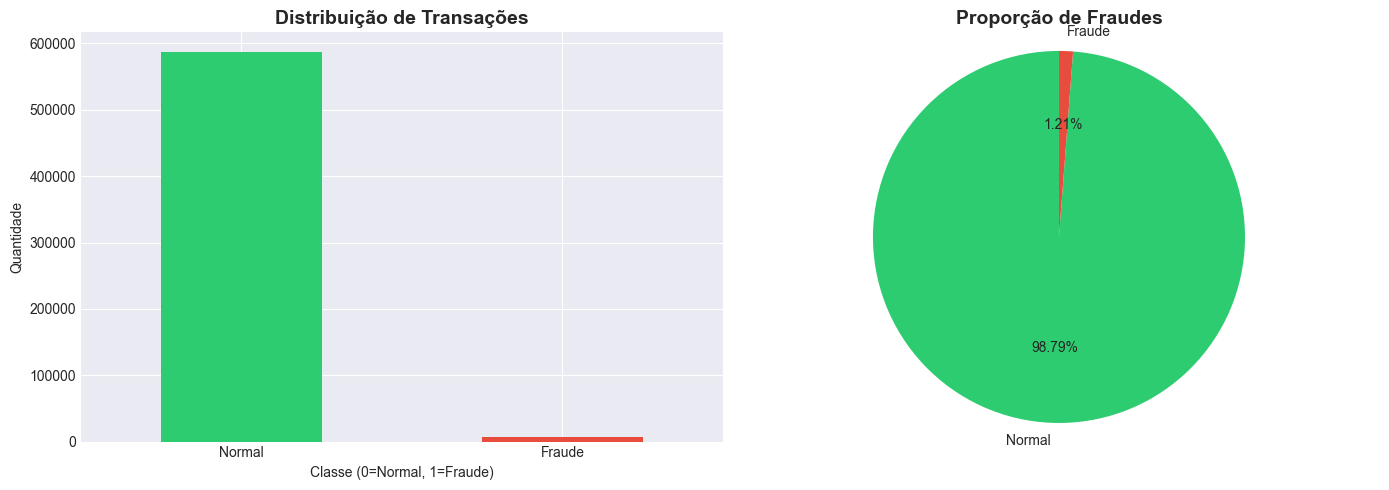

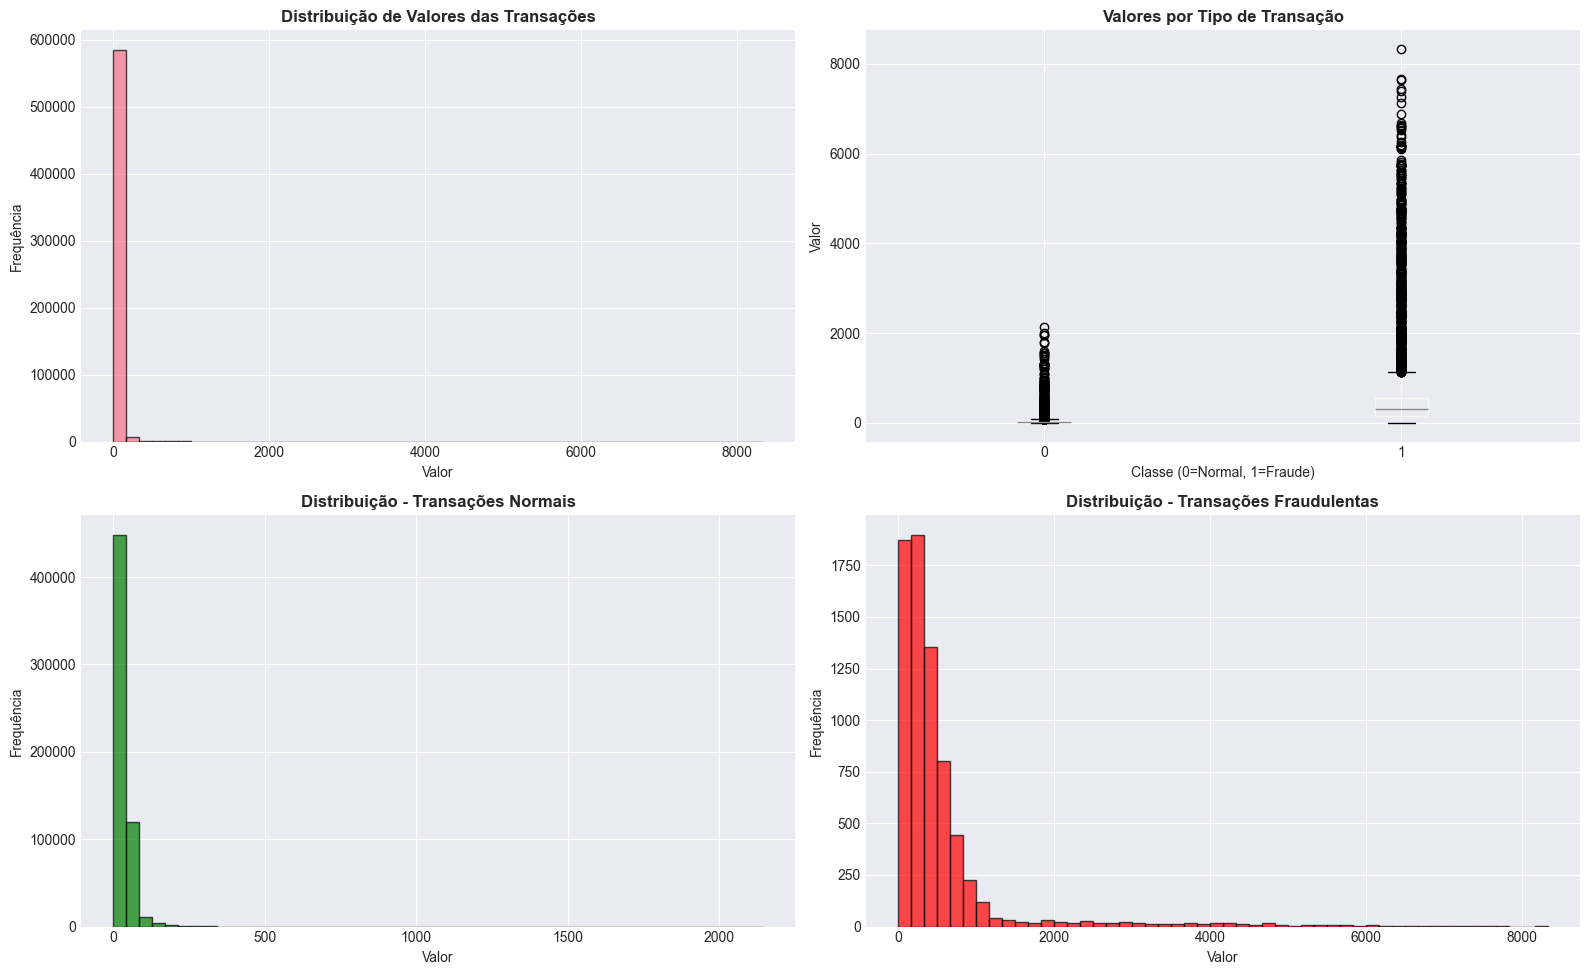


Estatísticas de valores por classe:
          count        mean         std   min     25%      50%       75%  \
fraud                                                                      
0      587443.0   31.847230   31.470876  0.00   13.59   26.610   41.8950   
1        7200.0  530.926551  835.587112  0.03  159.98  319.175  548.9775   

           max  
fraud           
0      2144.86  
1      8329.96  


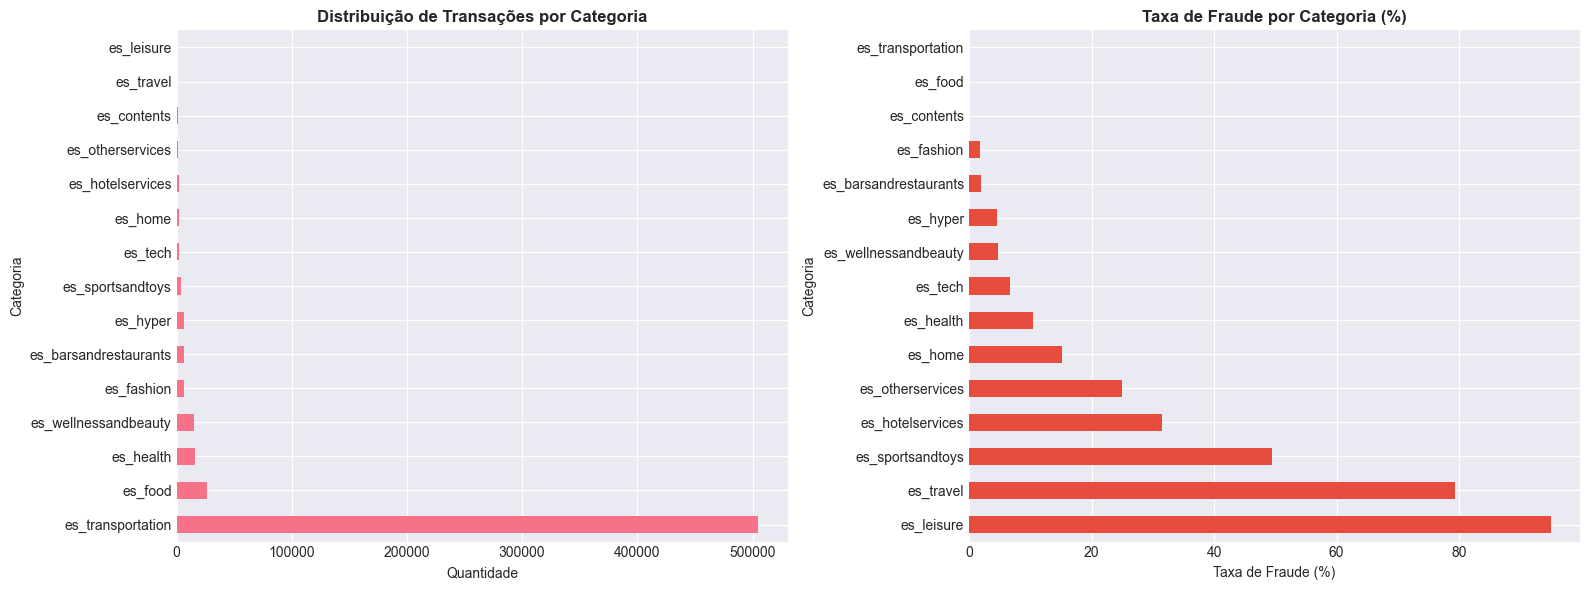


Taxa de fraude por categoria:
                        sum   count       rate
category                                      
es_leisure              474     499  94.989980
es_travel               578     728  79.395604
es_sportsandtoys       1982    4002  49.525237
es_hotelservices        548    1744  31.422018
es_otherservices        228     912  25.000000
es_home                 302    1986  15.206445
es_health              1696   16133  10.512614
es_tech                 158    2370   6.666667
es_wellnessandbeauty    718   15086   4.759380
es_hyper                280    6098   4.591669
es_barsandrestaurants   120    6373   1.882944
es_fashion              116    6454   1.797335
es_contents               0     885   0.000000
es_food                   0   26254   0.000000
es_transportation         0  505119   0.000000


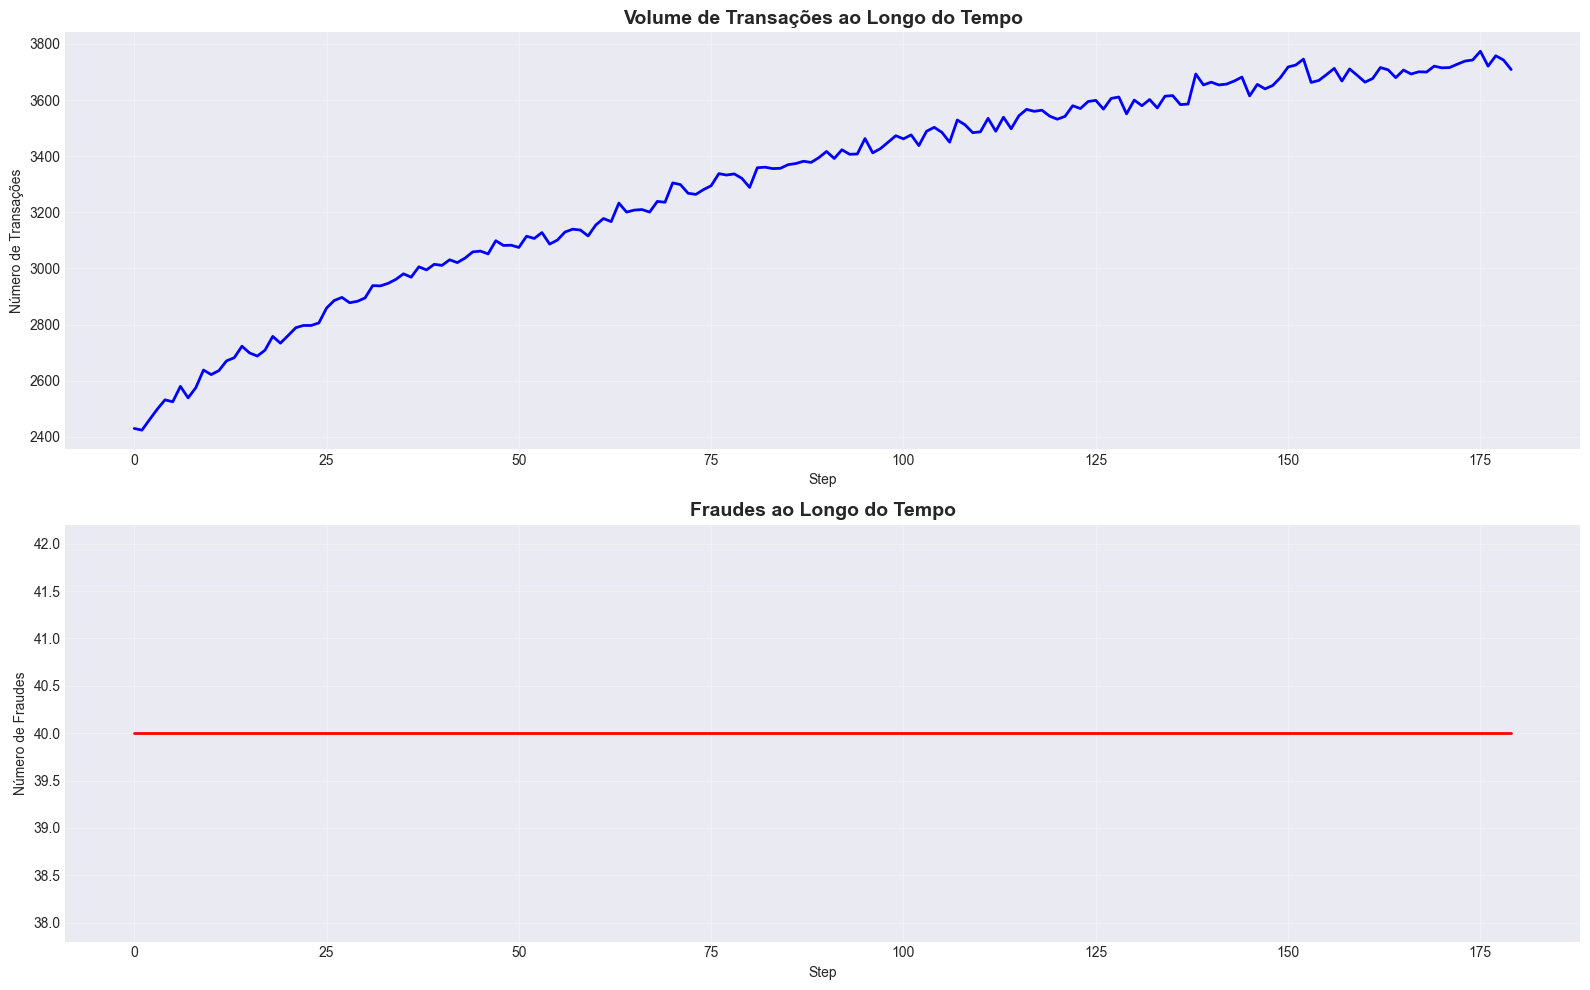

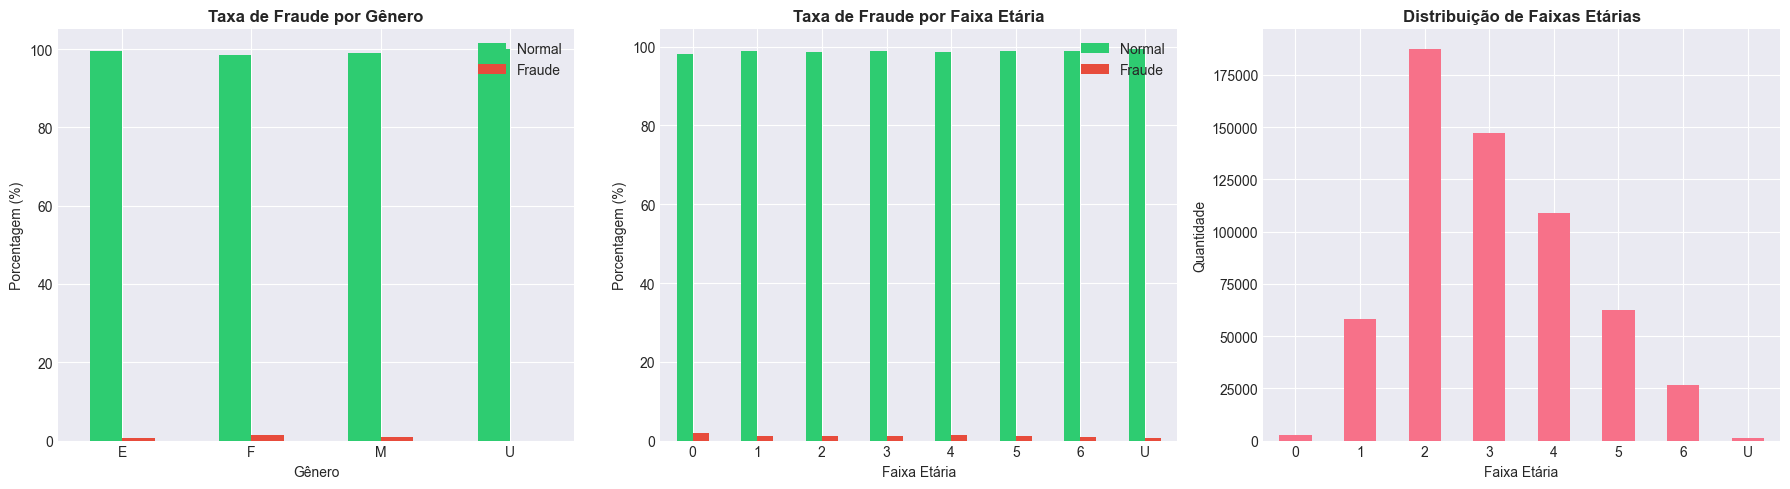

In [29]:
from eda.eda_basic import (plot_target_distribution, 
                           plot_amount_distribution,
                           plot_category_distribution,
                           plot_step_distribution,
                           plot_gender_distribution
                          )

plot_target_distribution(df)
plot_amount_distribution(df)
plot_category_distribution(df)
plot_step_distribution(df)
plot_gender_distribution(df)

## 3. Feature Engineering

Vamos criar features baseadas em regras de negócio e padrões comportamentais.

In [30]:
# Criando uma cópia do dataframe para feature engineering
from features.v1.feature_pipeline import build_features

df_features = df.copy()

print("Iniciando Feature Engineering...")
print(f"Shape inicial: {df_features.shape}")

df_features = build_features(df_features)

print(f"\nShape Final: {df_features.shape}")

Iniciando Feature Engineering...
Shape inicial: (594643, 10)

=== Features Baseadas no Cliente ===
✓ Frequência por cliente no step
✓ Perfil estatístico do cliente (média e std)
✓ Valor relativo à média histórica
✓ Total de transações por cliente
✓ Volume total por cliente
✓ Diversidade de categorias
✓ Diversidade de merchants

=== Features Temporais ===
✓ Transações nos últimos 5 steps
✓ Tempo desde última transação
✓ Média de valor dos últimos 5 steps
✓ Desvio em relação aos últimos 5 steps

=== Features de Relacionamento ===
✓ Frequência do par cliente-merchant
✓ Indicador de primeira transação
✓ Proporção de transações no merchant

=== Features de Localização ===
✓ Indicador de mesma localização
✓ Diversidade de localizações do cliente

Shape Final: (594643, 29)


In [31]:
# Visualizando as novas features criadas
print("\nNovas features criadas:")
new_features = [col for col in df_features.columns if col not in df.columns]
for i, feat in enumerate(new_features, 1):
    print(f"{i:2d}. {feat}")


Novas features criadas:
 1. qtd_transacoes
 2. alert_freq
 3. amount_mean_cliente
 4. amount_std_cliente
 5. alert_valor
 6. valor_relativo_cliente
 7. total_tx_cliente
 8. volume_total_cliente
 9. num_categorias_cliente
10. num_merchants_cliente
11. tx_ultimos_5_steps
12. step_diff
13. amount_media_5steps
14. amount_desvio_5steps
15. tx_cliente_merchant
16. primeira_tx_merchant
17. prop_tx_merchant
18. mesma_localizacao
19. num_zipcodes_cliente


In [32]:
display(df_features)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud,...,num_merchants_cliente,tx_ultimos_5_steps,step_diff,amount_media_5steps,amount_desvio_5steps,tx_cliente_merchant,primeira_tx_merchant,prop_tx_merchant,mesma_localizacao,num_zipcodes_cliente
0,30,C1000148617,5,M,28007,M1888755466,28007,es_otherservices,143.87,0,...,14,1.0,0.0,143.870000,0.000000,2,0,0.015267,1,1
1,38,C1000148617,5,M,28007,M1741626453,28007,es_sportsandtoys,16.69,0,...,14,2.0,8.0,80.280000,-63.590000,1,1,0.007634,1,1
2,42,C1000148617,5,M,28007,M1888755466,28007,es_otherservices,56.18,0,...,14,3.0,4.0,72.246667,-16.066667,2,0,0.015267,1,1
3,43,C1000148617,5,M,28007,M840466850,28007,es_tech,14.74,0,...,14,4.0,1.0,57.870000,-43.130000,1,1,0.007634,1,1
4,44,C1000148617,5,M,28007,M1823072687,28007,es_transportation,47.42,0,...,14,5.0,1.0,55.780000,-8.360000,92,0,0.702290,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,174,C999723254,2,M,28007,M1823072687,28007,es_transportation,31.94,0,...,11,5.0,1.0,25.540000,6.400000,77,0,0.631148,1,1
594639,176,C999723254,2,M,28007,M1823072687,28007,es_transportation,1.92,0,...,11,5.0,2.0,25.540000,-23.620000,77,0,0.631148,1,1
594640,177,C999723254,2,M,28007,M85975013,28007,es_food,62.55,0,...,11,5.0,1.0,33.714000,28.836000,8,0,0.065574,1,1
594641,178,C999723254,2,M,28007,M1823072687,28007,es_transportation,25.96,0,...,11,5.0,1.0,28.290000,-2.330000,77,0,0.631148,1,1



Top 15 features mais correlacionadas com fraude:
amount                    0.489967
amount_mean_cliente       0.469400
amount_media_5steps       0.436149
volume_total_cliente      0.389343
valor_relativo_cliente    0.384939
amount_std_cliente        0.328909
amount_desvio_5steps      0.287777
alert_valor               0.241227
qtd_transacoes            0.223978
num_merchants_cliente     0.215205
primeira_tx_merchant      0.200013
num_categorias_cliente    0.157940
step_diff                 0.127883
alert_freq                0.070175
step                     -0.011898
Name: fraud, dtype: float64


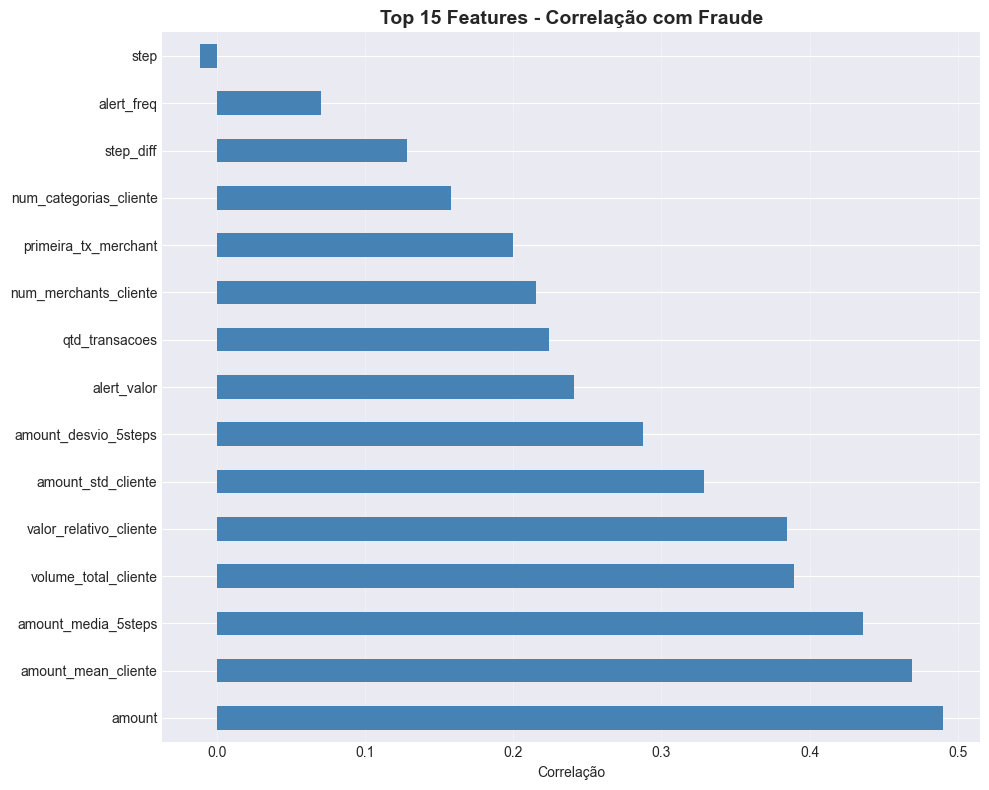

In [33]:
# Análise da correlação das features com fraude
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
correlation = df_features[numeric_cols].corr()['fraud'].sort_values(ascending=False)

print("\nTop 15 features mais correlacionadas com fraude:")
print(correlation[1:16])

# Visualização
plt.figure(figsize=(10, 8))
correlation[1:16].plot(kind='barh', color='steelblue')
plt.title('Top 15 Features - Correlação com Fraude', fontsize=14, fontweight='bold')
plt.xlabel('Correlação')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Preparação dos Dados para Modelagem

In [34]:
# Encoding de variáveis categóricas
le_gender = LabelEncoder()
le_category = LabelEncoder()

df_features['gender_encoded'] = le_gender.fit_transform(df_features['gender'])
df_features['category_encoded'] = le_category.fit_transform(df_features['category'])

print("✅ Encoding realizado com sucesso!")

✅ Encoding realizado com sucesso!


In [35]:
features_originais_lst = ['step', 'age', 'gender_encoded', 'category_encoded', 'amount'] 
features_clientes_lst  = ['qtd_transacoes', 'alert_freq', 'alert_valor', 'valor_relativo_cliente', 
                         'total_tx_cliente', 'volume_total_cliente', 'num_categorias_cliente', 
						 'num_merchants_cliente', 'amount_mean_cliente', 'amount_std_cliente'] 
features_temporias_lst = ['tx_ultimos_5_steps', 'step_diff', 'amount_media_5steps', 'amount_desvio_5steps'] 
features_marchant_lst  = ['amount_std_merchant'] 
                         #'tx_por_merchant_train', 'fraude_merchant_train', 'amount_mean_merchant', -> Foram excluídas por leakage 
features_relacionamento_lst = ['tx_cliente_merchant', 'primeira_tx_merchant', 'prop_tx_merchant'] 
features_localização_lst = ['mesma_localizacao', 'num_zipcodes_cliente'] 
features_categoria_lst = ['amount_mean_categoria', 'amount_desvio_categoria'] 
                          #'fraude_categoria', -> Foram excluídas por leakage 
features_scores_lst    = ['qtd_alertas', 'score_regra'] 

features_to_use = (features_originais_lst + 
                   features_clientes_lst + 
				   features_temporias_lst + 
				   features_marchant_lst + 
				   features_relacionamento_lst + 
				   features_localização_lst + 
				   features_categoria_lst + 
				   features_scores_lst 
				  ) 
				  
# Verificar se todas as features existem
missing_features = [f for f in features_to_use if f not in df_features.columns]
if missing_features:
    print(f"⚠️ Features faltando: {missing_features}")
    features_to_use = [f for f in features_to_use if f in df_features.columns]

X = df_features[features_to_use].copy()
y = df_features['fraud'].copy()

# Garantir que X contém apenas valores numéricos
X = X.apply(pd.to_numeric, errors='coerce')

# Substituir inf e -inf por NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Preencher NaN com 0
X = X.fillna(0)

print(f"Features selecionadas: {len(features_to_use)}")
print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nTipos de dados em X:")
print(X.dtypes.value_counts())

⚠️ Features faltando: ['amount_std_merchant', 'amount_mean_categoria', 'amount_desvio_categoria', 'qtd_alertas', 'score_regra']
Features selecionadas: 24

Shape de X: (594643, 24)
Shape de y: (594643,)

Tipos de dados em X:
float64    11
int64       7
int32       6
Name: count, dtype: int64


## 5. Separação dos dados 

In [36]:
# Split treino/teste com estratificação
from models.v1.base_model import split_data

X_train, X_test, y_train, y_test = split_data(
    X, y, test_size=0.2, random_state=42
)

print("Divisão treino/teste:")
print(f"Treino: {X_train.shape[0]:,} amostras")
print(f"Teste:  {X_test.shape[0]:,} amostras")
print(f"\nDistribuição no treino:")
print(y_train.value_counts())
print(f"\nDistribuição no teste:")
print(y_test.value_counts())

Divisão treino/teste:
Treino: 475,714 amostras
Teste:  118,929 amostras

Distribuição no treino:
fraud
0    469954
1      5760
Name: count, dtype: int64

Distribuição no teste:
fraud
0    117489
1      1440
Name: count, dtype: int64


## 6. Normalização das features

In [37]:
# Normalização das features
from models.v1.scaler import scaler_data

X_train_scaled, X_test_scaled, scaler = scaler_data(X_train, X_test)

print("✅ Normalização concluída!")

✅ Normalização concluída!


## 7. Modelagem de Machine Learning

Vamos testar diferentes algoritmos e comparar os resultados.

In [38]:
# Logistic Regression
from models.v1.pipeline import pipeline

model_type = "lr"
lr_results = pipeline(X_train_scaled, X_test_scaled, y_train, y_test, model_type)


Treinando: Logistic Regression

Métricas no conjunto de teste:
  Precision: 0.2465
  Recall:    0.9819
  F1-Score:  0.3940
  ROC-AUC:   0.9956
  Tempo (1000): 10.2197s

Matriz de Confusão:
[[113166   4323]
 [    26   1414]]

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98    117489
      Fraude       0.25      0.98      0.39      1440

    accuracy                           0.96    118929
   macro avg       0.62      0.97      0.69    118929
weighted avg       0.99      0.96      0.97    118929

✅ Função de avaliação criada!


In [39]:
# Random Forest
from models.v1.pipeline import pipeline

model_type = "rf"
rf_results = pipeline(X_train, X_test, y_train, y_test, model_type)


Treinando: Random Forest

Métricas no conjunto de teste:
  Precision: 0.7305
  Recall:    0.8736
  F1-Score:  0.7957
  ROC-AUC:   0.9980
  Tempo (1000): 51.6875s

Matriz de Confusão:
[[117025    464]
 [   182   1258]]

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    117489
      Fraude       0.73      0.87      0.80      1440

    accuracy                           0.99    118929
   macro avg       0.86      0.93      0.90    118929
weighted avg       1.00      0.99      0.99    118929

✅ Função de avaliação criada!


In [40]:
# Gradient Boosting
from models.v1.pipeline import pipeline

model_type = "gb"
gb_results = pipeline(X_train, X_test, y_train, y_test, model_type)


Treinando: Gradient Boosting

Métricas no conjunto de teste:
  Precision: 0.9180
  Recall:    0.8007
  F1-Score:  0.8553
  ROC-AUC:   0.9982
  Tempo (1000): 615.3868s

Matriz de Confusão:
[[117386    103]
 [   287   1153]]

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    117489
      Fraude       0.92      0.80      0.86      1440

    accuracy                           1.00    118929
   macro avg       0.96      0.90      0.93    118929
weighted avg       1.00      1.00      1.00    118929

✅ Função de avaliação criada!


## 8. Comparação de Modelos


COMPARAÇÃO DE MODELOS
              Model  Precision   Recall  F1-Score  ROC-AUC      Tempo
Logistic Regression   0.246470 0.981944  0.394037 0.995622  10.219705
      Random Forest   0.730546 0.873611  0.795699 0.998023  51.687544
  Gradient Boosting   0.917994 0.800694  0.855341 0.998225 615.386806


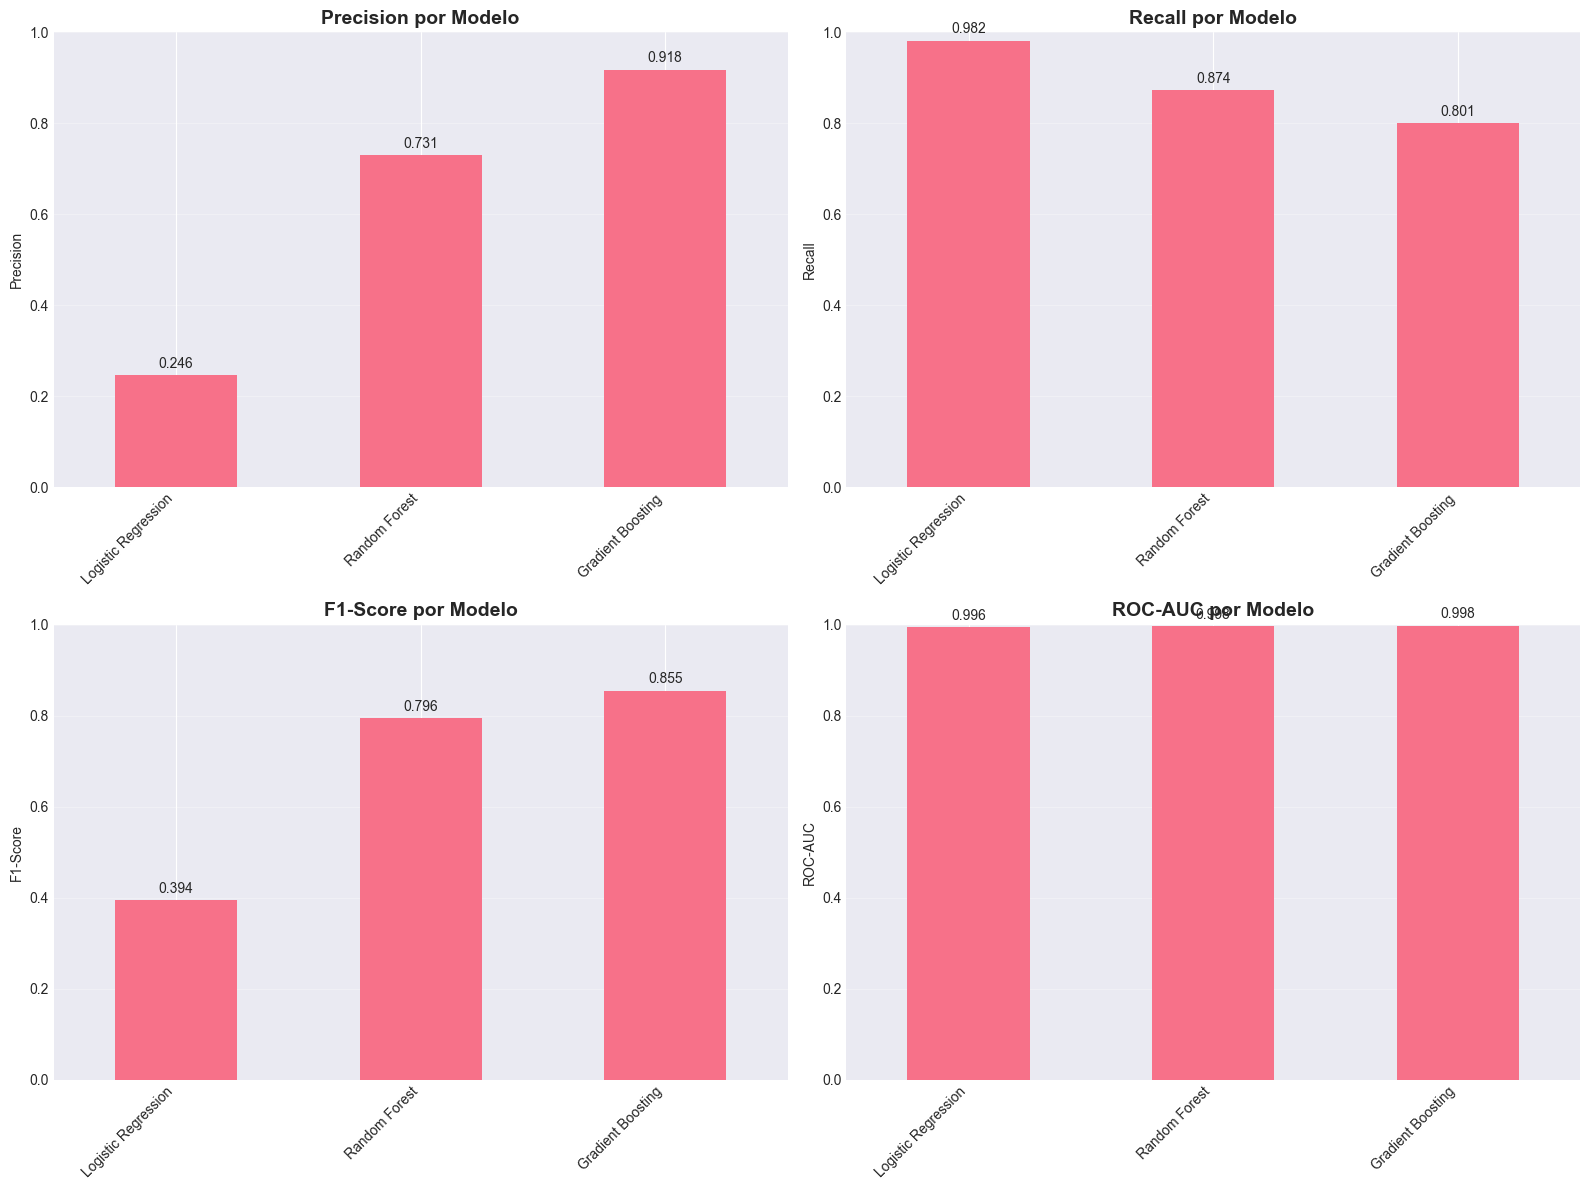

In [47]:
# Comparação de métricas
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Precision': [lr_results['precision'], rf_results['precision'], gb_results['precision']],
    'Recall': [lr_results['recall'], rf_results['recall'], gb_results['recall']],
    'F1-Score': [lr_results['f1'], rf_results['f1'], gb_results['f1']],
    'ROC-AUC': [lr_results['roc_auc'], rf_results['roc_auc'], gb_results['roc_auc']],
    'Tempo': [lr_results['tempo'], rf_results['tempo'], gb_results['tempo']]
})

print("\n" + "="*70)
print("COMPARAÇÃO DE MODELOS")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False)
    ax.set_title(f'{metric} por Modelo', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    # Adicionando valores nas barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

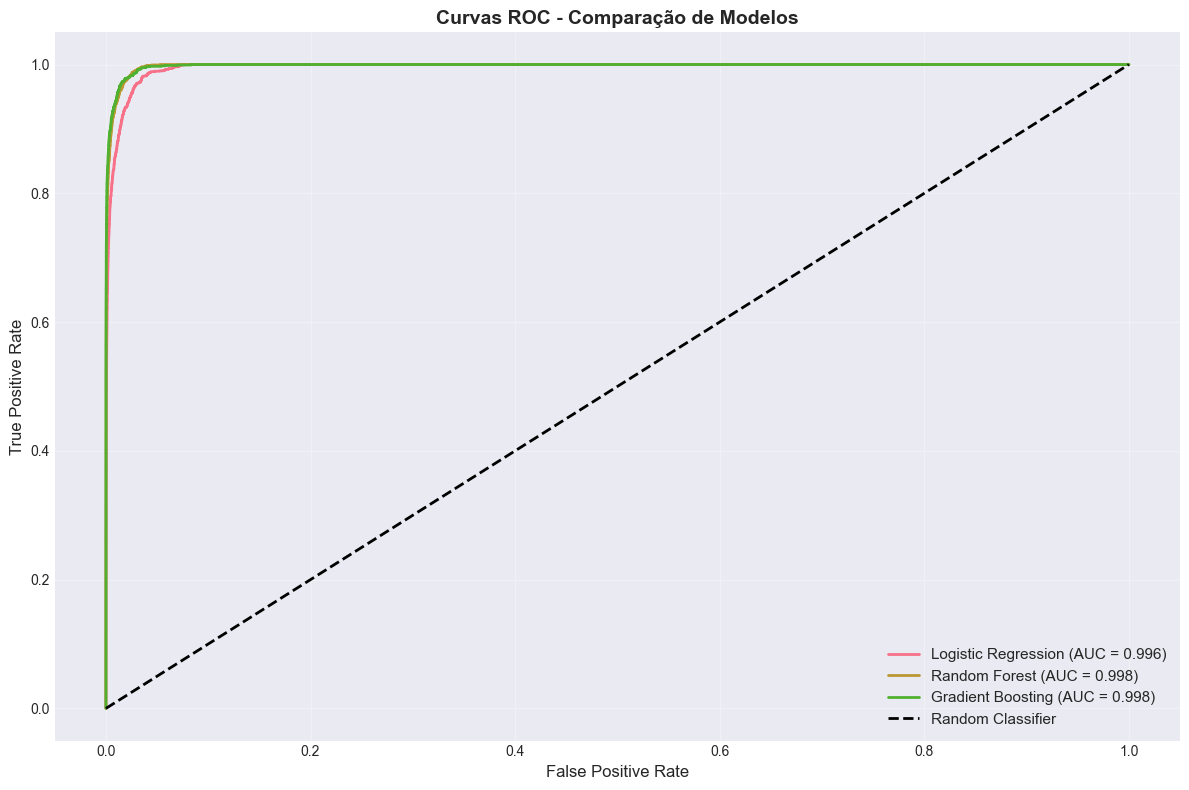

In [42]:
# Curvas ROC
plt.figure(figsize=(12, 8))

models_results = [
    ('Logistic Regression', lr_results),
    ('Random Forest', rf_results),
    ('Gradient Boosting', gb_results)
]

for name, results in models_results:
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - Comparação de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

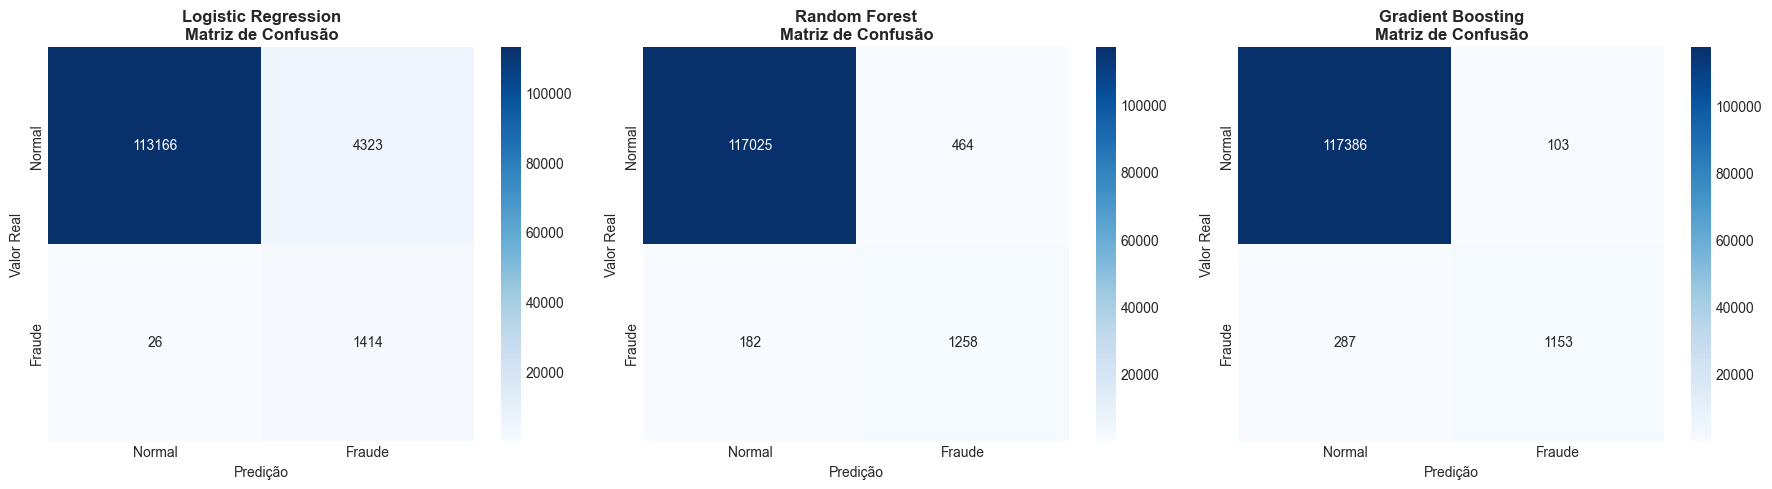

In [43]:
# Matrizes de Confusão
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, results) in enumerate(models_results):
    sns.heatmap(
        results['cm'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Normal', 'Fraude'],
        yticklabels=['Normal', 'Fraude'],
        ax=axes[idx]
    )
    axes[idx].set_title(f'{name}\nMatriz de Confusão', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Valor Real')
    axes[idx].set_xlabel('Predição')

plt.tight_layout()
plt.show()

## 9. Feature Importance (Random Forest)


Top 20 Features mais importantes (Random Forest):
                   feature  importance
17     amount_media_5steps    0.164436
4                   amount    0.164365
19     tx_cliente_merchant    0.147999
21        prop_tx_merchant    0.118458
13     amount_mean_cliente    0.094397
14      amount_std_cliente    0.070536
3         category_encoded    0.051386
18    amount_desvio_5steps    0.043659
5           qtd_transacoes    0.024110
12   num_merchants_cliente    0.022191
8   valor_relativo_cliente    0.021604
10    volume_total_cliente    0.020218
9         total_tx_cliente    0.014246
20    primeira_tx_merchant    0.011789
16               step_diff    0.010481
11  num_categorias_cliente    0.007310
0                     step    0.005074
7              alert_valor    0.004430
1                      age    0.001660
15      tx_ultimos_5_steps    0.001000


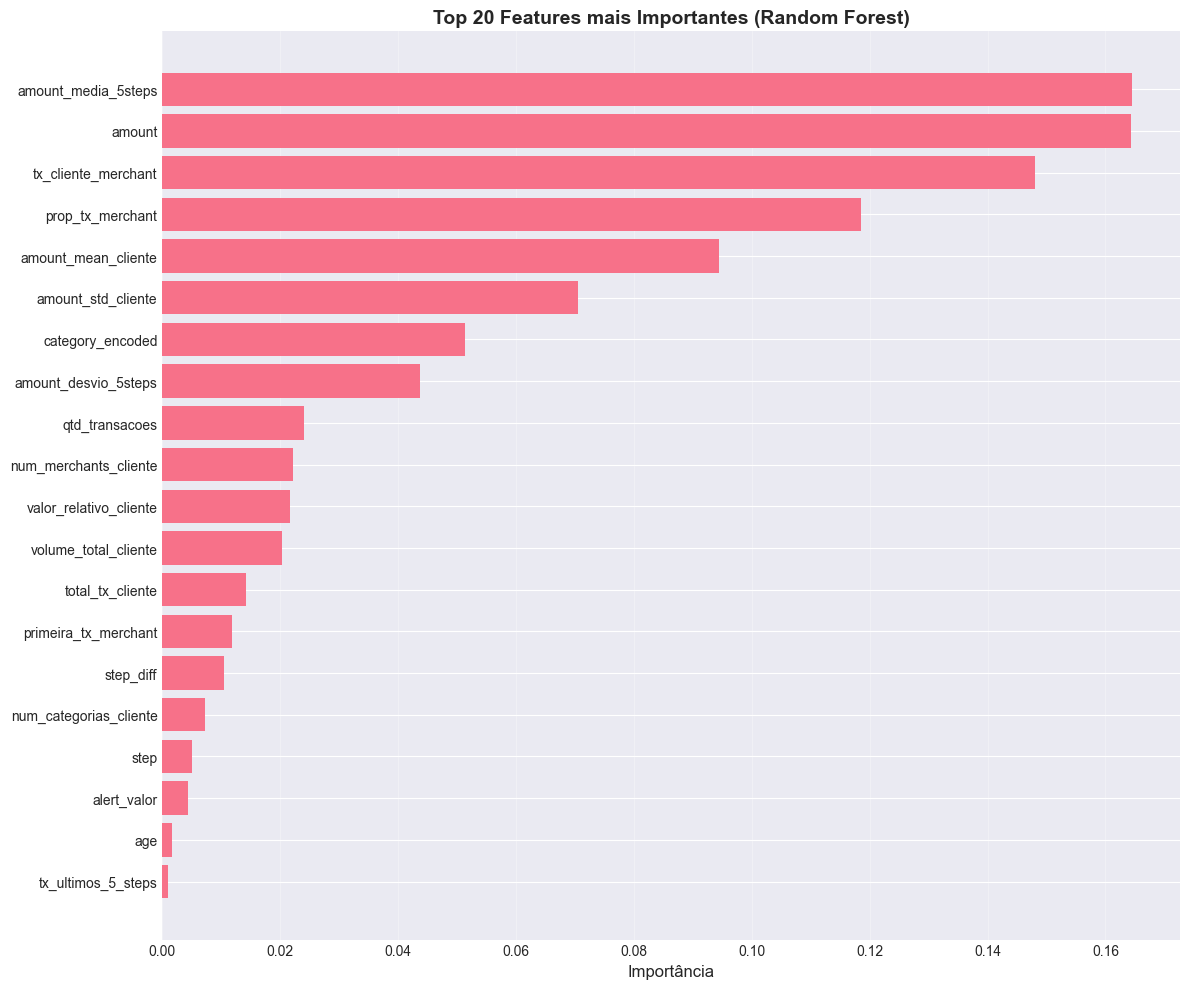

In [44]:
# Importância das features no Random Forest
feature_importance = pd.DataFrame({
    'feature': features_to_use,
    'importance': rf_results['model'].feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features mais importantes (Random Forest):")
print(feature_importance.head(20))

# Visualização
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância', fontsize=12)
plt.title('Top 20 Features mais Importantes (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Conclusões e Próximos Passos

### Principais Insights:

1. **Desbalanceamento**: O dataset é altamente desbalanceado (1.21% de fraudes)
2. **Features Importantes**: As features engineered mostraram-se muito relevantes
3. **Modelos**: Random Forest e Gradient Boosting obtiveram os melhores resultados

### Features Mais Importantes:
- Taxa de fraude do merchant
- Taxa de fraude da categoria
- Valor relativo ao perfil do cliente
- Score de risco baseado em regras
- Frequência de transações


In [45]:
print("\n" + "="*70)
print("RESUMO DO PROJETO DE DETECÇÃO DE FRAUDES")
print("="*70)
print(f"\n📁 Dataset: BankSim")
print(f"   Total de transações: {len(df):,}")
print(f"   Transações normais: {len(df[df['fraud']==0]):,} ({(len(df[df['fraud']==0])/len(df)*100):.2f}%)")
print(f"   Transações fraudulentas: {len(df[df['fraud']==1]):,} ({(len(df[df['fraud']==1])/len(df)*100):.2f}%)")

print(f"\n🔧 Features:")
print(f"   Features originais: {len(df.columns)}")
print(f"   Features engineered: {len(new_features)}")
print(f"   Total de features para modelagem: {len(features_to_use)}")

print(f"\n🤖 Modelos Treinados: 3")
print(f"   1. Logistic Regression")
print(f"   2. Random Forest")
print(f"   3. Gradient Boosting")

print(f"\n🏆 Melhor Modelo: Random Forest")
print(f"   ROC-AUC: {rf_results['roc_auc']:.4f}")
print(f"   F1-Score: {rf_results['f1']:.4f}")
print(f"   Precision: {rf_results['precision']:.4f}")
print(f"   Recall: {rf_results['recall']:.4f}")

print("\n" + "="*70)
print("✅ Análise Completa!")
print("="*70)


RESUMO DO PROJETO DE DETECÇÃO DE FRAUDES

📁 Dataset: BankSim
   Total de transações: 594,643
   Transações normais: 587,443 (98.79%)
   Transações fraudulentas: 7,200 (1.21%)

🔧 Features:
   Features originais: 10
   Features engineered: 19
   Total de features para modelagem: 24

🤖 Modelos Treinados: 3
   1. Logistic Regression
   2. Random Forest
   3. Gradient Boosting

🏆 Melhor Modelo: Random Forest
   ROC-AUC: 0.9980
   F1-Score: 0.7957
   Precision: 0.7305
   Recall: 0.8736

✅ Análise Completa!
